In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Load Data

In [7]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [38]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [10]:
num_classes = len(dataset.classes)
num_classes

6

In [11]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [12]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [14]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [15]:
labels[1]

tensor(2)

In [16]:
images[1].shape

torch.Size([3, 224, 224])

In [17]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.0125492].


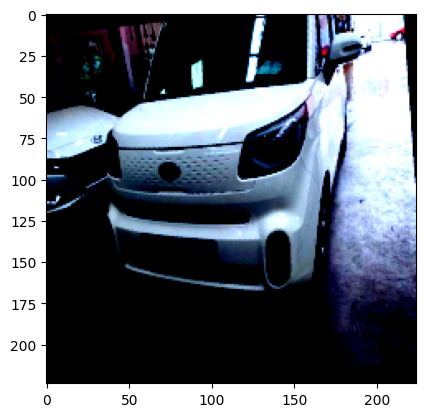

In [18]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1: CNN

In [19]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32, 56, 56),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [20]:
#Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for  batch_num, (images, labels) in enumerate (train_loader):
            images, labels = images.to(device), labels.to(device)

            #Zero the parameter gradients
            optimizer.zero_grad()

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        #Validation
        model.eval()
        correct= 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return all_labels, all_predictions     

In [22]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.74
Batch: 20, Epoch: 1, Loss: 1.71
Batch: 30, Epoch: 1, Loss: 1.65
Batch: 40, Epoch: 1, Loss: 1.66
Batch: 50, Epoch: 1, Loss: 1.62
Epoch [1/5], Avg Loss: 1.8559
*** Validation Accuracy: 40.35% ***
Batch: 10, Epoch: 2, Loss: 1.52
Batch: 20, Epoch: 2, Loss: 1.56
Batch: 30, Epoch: 2, Loss: 1.62
Batch: 40, Epoch: 2, Loss: 1.43
Batch: 50, Epoch: 2, Loss: 1.30
Epoch [2/5], Avg Loss: 1.4328
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 3, Loss: 1.27
Batch: 20, Epoch: 3, Loss: 1.39
Batch: 30, Epoch: 3, Loss: 1.36
Batch: 40, Epoch: 3, Loss: 1.04
Batch: 50, Epoch: 3, Loss: 1.66
Epoch [3/5], Avg Loss: 1.3235
*** Validation Accuracy: 48.35% ***
Batch: 10, Epoch: 4, Loss: 1.33
Batch: 20, Epoch: 4, Loss: 1.28
Batch: 30, Epoch: 4, Loss: 1.11
Batch: 40, Epoch: 4, Loss: 0.95
Batch: 50, Epoch: 4, Loss: 1.19
Epoch [4/5], Avg Loss: 1.2360
*** Validation Accuracy: 51.65% ***
Batch: 10, Epoch: 5, Loss: 1.30
Batch: 20, Epoch: 5, Loss: 1.21
Batch: 30, Epoch: 5, Loss: 0.93


### Model 2: CNN with Regularization

In [23]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32, 56, 56),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [24]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 12.89
Batch: 20, Epoch: 1, Loss: 7.44
Batch: 30, Epoch: 1, Loss: 1.65
Batch: 40, Epoch: 1, Loss: 1.63
Batch: 50, Epoch: 1, Loss: 1.55
Epoch [1/10], Avg Loss: 7.5134
*** Validation Accuracy: 48.17% ***
Batch: 10, Epoch: 2, Loss: 1.48
Batch: 20, Epoch: 2, Loss: 1.48
Batch: 30, Epoch: 2, Loss: 1.39
Batch: 40, Epoch: 2, Loss: 1.23
Batch: 50, Epoch: 2, Loss: 1.39
Epoch [2/10], Avg Loss: 1.4786
*** Validation Accuracy: 50.96% ***
Batch: 10, Epoch: 3, Loss: 1.45
Batch: 20, Epoch: 3, Loss: 1.53
Batch: 30, Epoch: 3, Loss: 1.68
Batch: 40, Epoch: 3, Loss: 1.34
Batch: 50, Epoch: 3, Loss: 1.16
Epoch [3/10], Avg Loss: 1.3944
*** Validation Accuracy: 51.13% ***
Batch: 10, Epoch: 4, Loss: 1.25
Batch: 20, Epoch: 4, Loss: 1.20
Batch: 30, Epoch: 4, Loss: 1.41
Batch: 40, Epoch: 4, Loss: 1.50
Batch: 50, Epoch: 4, Loss: 1.21
Epoch [4/10], Avg Loss: 1.3348
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 5, Loss: 1.22
Batch: 20, Epoch: 5, Loss: 0.98
Batch: 30, Epoch: 5, Loss: 

([np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(5),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(5),
  np.int64(2),
  np.int64

### Model 3: Transfer Learning with EfficientNet

In [25]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Alamgir/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:12<00:00, 1.76MB/s]


1280

In [26]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)  
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.67
Batch: 20, Epoch: 1, Loss: 1.57
Batch: 30, Epoch: 1, Loss: 1.39
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.27
Epoch [1/10], Avg Loss: 1.4856
*** Validation Accuracy: 61.39% ***
Batch: 10, Epoch: 2, Loss: 1.22
Batch: 20, Epoch: 2, Loss: 0.97
Batch: 30, Epoch: 2, Loss: 1.01
Batch: 40, Epoch: 2, Loss: 1.29
Batch: 50, Epoch: 2, Loss: 0.96
Epoch [2/10], Avg Loss: 1.1539
*** Validation Accuracy: 66.26% ***
Batch: 10, Epoch: 3, Loss: 0.81
Batch: 20, Epoch: 3, Loss: 0.99
Batch: 30, Epoch: 3, Loss: 1.00
Batch: 40, Epoch: 3, Loss: 1.06
Batch: 50, Epoch: 3, Loss: 1.00
Epoch [3/10], Avg Loss: 1.0235
*** Validation Accuracy: 68.70% ***
Batch: 10, Epoch: 4, Loss: 1.00
Batch: 20, Epoch: 4, Loss: 0.77
Batch: 30, Epoch: 4, Loss: 1.22
Batch: 40, Epoch: 4, Loss: 1.00
Batch: 50, Epoch: 4, Loss: 1.03
Epoch [4/10], Avg Loss: 0.9773
*** Validation Accuracy: 68.52% ***
Batch: 10, Epoch: 5, Loss: 1.03
Batch: 20, Epoch: 5, Loss: 0.75
Batch: 30, Epoch: 5, Loss: 0

([np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(5),
  np.int64(3),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(3),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(4),
  np.int64(3),
  np.int64(4),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64

### Model 4: Transfer Learning with ResNet

In [29]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)  
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [30]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Alamgir/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:58<00:00, 1.74MB/s]


Batch: 10, Epoch: 1, Loss: 1.06
Batch: 20, Epoch: 1, Loss: 0.83
Batch: 30, Epoch: 1, Loss: 0.83
Batch: 40, Epoch: 1, Loss: 0.71
Batch: 50, Epoch: 1, Loss: 0.57
Epoch [1/10], Avg Loss: 0.9170
*** Validation Accuracy: 71.13% ***
Batch: 10, Epoch: 2, Loss: 0.30
Batch: 20, Epoch: 2, Loss: 0.50
Batch: 30, Epoch: 2, Loss: 0.58
Batch: 40, Epoch: 2, Loss: 0.56
Batch: 50, Epoch: 2, Loss: 0.64
Epoch [2/10], Avg Loss: 0.4927
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 3, Loss: 0.34
Batch: 20, Epoch: 3, Loss: 0.18
Batch: 30, Epoch: 3, Loss: 0.27
Batch: 40, Epoch: 3, Loss: 0.21
Batch: 50, Epoch: 3, Loss: 0.30
Epoch [3/10], Avg Loss: 0.3636
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 4, Loss: 0.17
Batch: 20, Epoch: 4, Loss: 0.19
Batch: 30, Epoch: 4, Loss: 0.25
Batch: 40, Epoch: 4, Loss: 0.15
Batch: 50, Epoch: 4, Loss: 0.16
Epoch [4/10], Avg Loss: 0.2213
*** Validation Accuracy: 79.48% ***
Batch: 10, Epoch: 5, Loss: 0.22
Batch: 20, Epoch: 5, Loss: 0.23
Batch: 30, Epoch: 5, Loss: 0

 ### Model Evaluation using Confusion Matrix and Classification Report

In [31]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       130
           1       0.67      0.78      0.72        90
           2       0.88      0.91      0.90       141
           3       0.63      0.80      0.71        65
           4       0.70      0.63      0.67        79
           5       0.86      0.73      0.79        70

    accuracy                           0.79       575
   macro avg       0.78      0.78      0.77       575
weighted avg       0.80      0.79      0.79       575



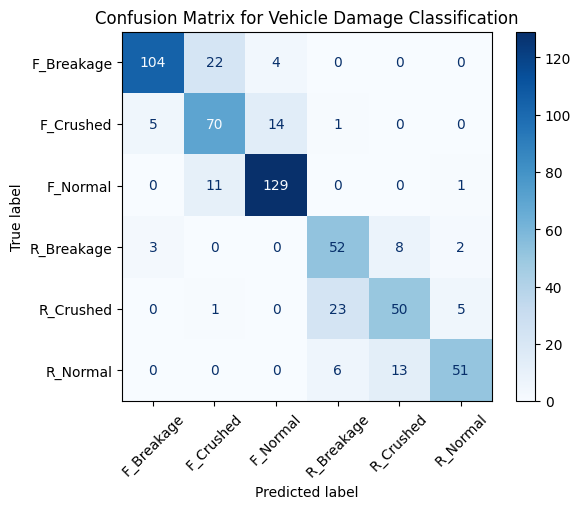

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [41]:
torch.save(model.state_dict(), 'saved_model.pth')